In [1]:
# !pip install langchain-community openai chroma transformers kagglehub

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dylanjcastillo/7k-books-with-metadata")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/7k-books-with-metadata


In [4]:
books = pd.read_csv(f"{path}/books.csv")
books.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0


In [5]:
books.describe()

,isbn13,published_year,average_rating,num_pages,ratings_count
count,6.810000e+03,6804.000000,6767.000000,6767.000000,6.767000e+03
mean,9.780677e+12,1998.630364,3.933284,348.181026,2.106910e+04
std,6.068911e+08,10.484257,0.331352,242.376783,1.376207e+05
min,9.780002e+12,1853.000000,0.000000,0.000000,0.000000e+00
25%,9.780330e+12,1996.000000,3.770000,208.000000,1.590000e+02
50%,9.780553e+12,2002.000000,3.960000,304.000000,1.018000e+03
75%,9.780810e+12,2005.000000,4.130000,420.000000,5.992500e+03
max,9.789042e+12,2019.000000,5.000000,3342.000000,5.629932e+06


In [6]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6810 entries, 0 to 6809
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   isbn13          6810 non-null   int64  
 1   isbn10          6810 non-null   object 
 2   title           6810 non-null   object 
 3   subtitle        2381 non-null   object 
 4   authors         6738 non-null   object 
 5   categories      6711 non-null   object 
 6   thumbnail       6481 non-null   object 
 7   description     6548 non-null   object 
 8   published_year  6804 non-null   float64
 9   average_rating  6767 non-null   float64
 10  num_pages       6767 non-null   float64
 11  ratings_count   6767 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 638.6+ KB


In [7]:
# Checking the number of missing values in each column of the dataset
books.isna().sum()

,0
isbn13,0
isbn10,0
title,0
subtitle,4429
authors,72
categories,99
thumbnail,329
description,262
published_year,6
average_rating,43


##  **Missing Values in Book Recommendation Dataset**

In any dataset, handling missing values is crucial for ensuring data quality and improving model performance. Below is a summary of missing values in our dataset:

| **Column Name**     | **Missing Values** |
|---------------------|------------------|
| `isbn13`           | **0**  |
| `isbn10`           | **0**  |
| `title`            | **0**  |
| `subtitle`         | **4429**  |
| `authors`          | **72**  |
| `categories`       | **99**  |
| `thumbnail`        | **329**  |
| `description`      | **262**  |
| `published_year`   | **6**  |
| `average_rating`   | **43**  |
| `num_pages`        | **43**  |
| `ratings_count`    | **43**  |

### **Observations:**
1. **No missing values in `isbn13`, `isbn10`, and `title`** → These are essential for book identification.  
2. **`subtitle` has the highest missing values(approximately 2/3rd of the data is missing)** → This is an optional field, so we can choose to drop or fill it with an empty string.  
3. **`authors` and `categories` have some missing values** → We may replace them with "Unknown" or remove those records if necessary.  
4. **`description`, `thumbnail`, and `published_year` have a few missing values** → Missing descriptions can be left empty, while missing years might be imputed based on other attributes.  
5. **`average_rating`, `num_pages`, and `ratings_count` have the same missing count (


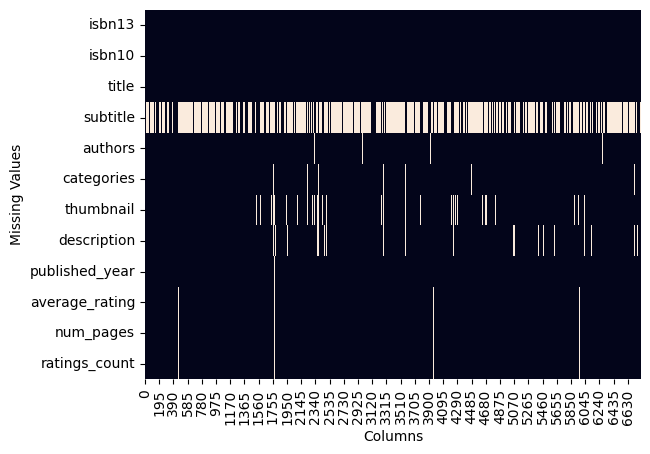

In [8]:
ax = plt.axes()
sns.heatmap(books.isna().transpose(), cbar=False, ax=ax)
plt.xlabel("Columns")
plt.ylabel("Missing Values")
plt.show()

In [9]:
books["missing_description"] = np.where(books["description"].isna(), 1, 0)
books["age_of_book"] = 2024 - books["published_year"]

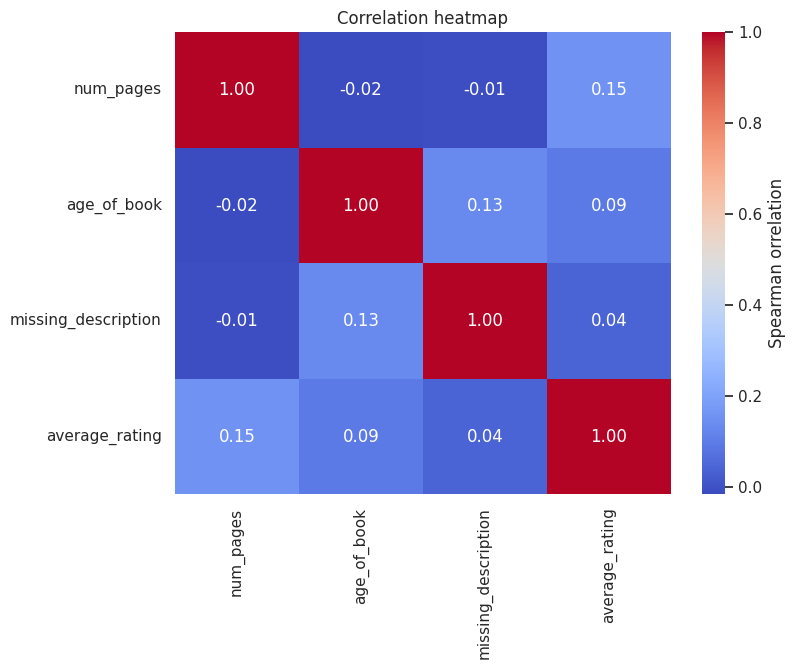

In [10]:
columns_of_interest = ["num_pages", "age_of_book", "missing_description", "average_rating"]
correlation_matrix = books[columns_of_interest].corr(method="spearman")
sns.set_theme(style="white")
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label":"Spearman orrelation"})
heatmap.set_title("Correlation heatmap")
plt.show()

## **Correlation Analysis of Book Features 📚**

Understanding the correlation between different features in our dataset helps in feature selection and understanding their impact on the recommendation system. The heatmap above represents **Spearman's correlation** between key attributes.

### **Observations:**
1. **`num_pages` has a slight positive correlation (0.15) with `average_rating`**  
   - Books with more pages tend to have slightly higher ratings, but the relationship is weak.  

2. **`age_of_book` shows a small positive correlation (0.13) with `missing_description`**  
   - Older books are slightly more likely to have missing descriptions.  

3. **`missing_description` has almost no correlation (0.04) with `average_rating`**  
   - The presence of a book description does not significantly impact ratings.  

4. **`age_of_book` has a minor correlation (0.09) with `average_rating`**  
   - Older books are rated slightly higher, but the effect is minimal.  

### **Key Takeaways:**
- No strong correlations exist, indicating that **each feature independently contributes** to the dataset.  
- **Feature engineering** may be required to derive more meaningful insights.  
- Further **exploratory data analysis (EDA)** can help identify hidden patterns.  

---
This correlation heatmap provides insights into feature relationships, guiding us in refining our book recommendation system.


In [11]:
# Filtering books with missing values in key columns
# This helps identify records that have missing descriptions, number of pages,
# average rating, or published year, which might impact our recommendation system.

books[(books["description"].isna()) |
      (books["num_pages"].isna()) |
      (books["average_rating"].isna()) |
      (books["published_year"].isna())]

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book
37,9780006906018,000690601X,The Princess of the Chalet School,NaN,Elinor Mary Brent-Dyer,Juvenile Fiction,http://books.google.com/books/content?id=EJcQP...,NaN,2000.0,4.10,159.0,446.0,1,24.0
60,9780007127740,000712774X,The illustrated man,NaN,Ray Bradbury,Fiction,http://books.google.com/books/content?id=kePql...,NaN,2002.0,4.14,186.0,56781.0,1,22.0
99,9780020442806,0020442807,"The Chronicles of Narnia: Lion, the witch and ...",NaN,Clive Staples Lewis,Fairy tales,NaN,NaN,1978.0,4.26,1425.0,1446.0,1,46.0
102,9780023513206,0023513209,Reason in History,A General Introduction to the Philosophy of Hi...,Georg Wilhelm Friedrich Hegel,Philosophy,http://books.google.com/books/content?id=BCvcY...,NaN,1953.0,3.64,95.0,430.0,1,71.0
105,9780026995016,0026995018,Spandau,The Secret Diaries,Albert Speer,History,NaN,NaN,1976.0,4.12,463.0,6.0,1,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6787,9783464371640,3464371646,About a Boy,NaN,Nick Hornby,NaN,http://books.google.com/books/content?id=PuDYw...,NaN,2002.0,3.80,256.0,155.0,1,22.0
6788,9783540292128,3540292128,Enzyme-Catalyzed Synthesis of Polymers,NaN,Shiro Kobayashi;Helmut Ritter;David Kaplan,Science,http://books.google.com/books/content?id=WXOym...,NaN,2006.0,0.00,254.0,0.0,1,18.0
6798,9787506435673,7506435675,Good Fight,NaN,Judd Winick;Matthew Clark,Juvenile Fiction,http://books.google.com/books/content?id=xGPZA...,Presents the adventures of a new group of hero...,2007.0,NaN,NaN,NaN,0,17.0
6806,9788185944609,8185944601,Secrets Of The Heart,NaN,Khalil Gibran,Mysticism,http://books.google.com/books/content?id=XcrVp...,NaN,1993.0,4.08,74.0,324.0,1,31.0


 Removing books with missing values in critical columns

 This filters out records where `description`, `num_pages`, `average_rating`,
 or `published_year` are missing, ensuring a cleaner dataset for analysis.

In [12]:
book_missing = books[~(books["description"].isna()) &
      ~(books["num_pages"].isna()) &
      ~(books["average_rating"].isna()) &
      ~(books["published_year"].isna())]
print(book_missing.shape)
book_missing

(6507, 14)


,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,20.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,24.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0,0,42.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,31.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6803,9788173031014,8173031010,Journey to the East,NaN,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,0,22.0
6804,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,NaN,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,0,21.0
6805,9788185300535,8185300534,I Am that,Talks with Sri Nisargadatta Maharaj,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,0,25.0
6808,9789027712059,9027712050,The Berlin Phenomenology,NaN,Georg Wilhelm Friedrich Hegel,History,http://books.google.com/books/content?id=Vy7Sk...,Since the three volume edition ofHegel's Philo...,1981.0,0.00,210.0,0.0,0,43.0


In [13]:
book_missing.isna().sum()

,0
isbn13,0
isbn10,0
title,0
subtitle,4226
authors,63
categories,33
thumbnail,214
description,0
published_year,0
average_rating,0


In [14]:
book_missing["categories"].value_counts().reset_index().sort_values("count", ascending=False)

,categories,count
0,Fiction,2523
1,Juvenile Fiction,534
2,Biography & Autobiography,391
3,History,258
4,Literary Criticism,164
...,...,...
519,"Adventure stories, English",1
518,Germany,1
517,Egypt,1
516,Apartments,1


Plotting a bar chart to visualize the top 10 most common book categories
 based on their occurrence in the dataset.


<ipython-input-15-2bc81d14449a>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_counts, x="Category", y="Count", palette="viridis")


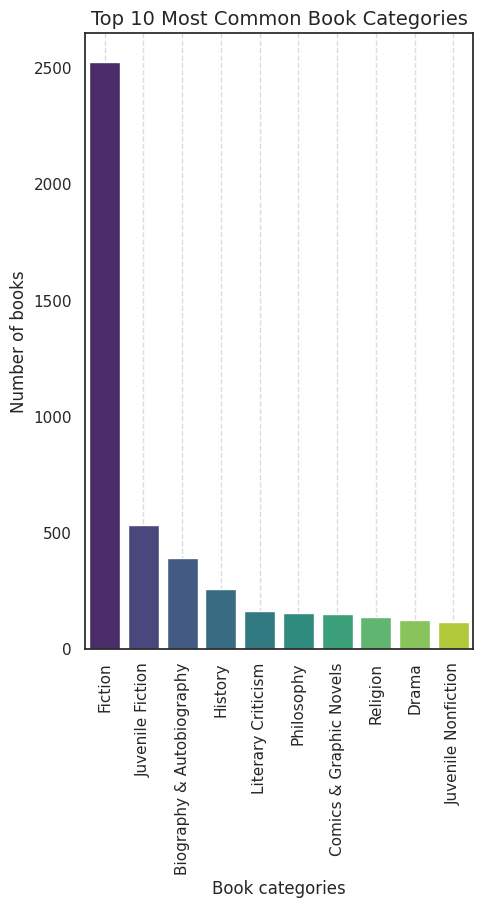

In [15]:
# Counting occurrences of each category
category_counts = book_missing["categories"].value_counts().reset_index()
category_counts.columns = ["Category", "Count"]

category_counts = category_counts.sort_values("Count", ascending=False).head(10)

# Plotting the bar chart
plt.figure(figsize=(5, 8))
sns.barplot(data=category_counts, x="Category", y="Count", palette="viridis")
plt.xticks(rotation=90)
# Adding labels and title
plt.ylabel("Number of books", fontsize=12)
plt.xlabel("Book categories", fontsize=12)
plt.title("Top 10 Most Common Book Categories", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

### Filtering Books with Meaningful Descriptions  

In this step, we refine our dataset by selecting only those rows where the book description contains more than 25 characters.  
Short descriptions (or missing ones) may not provide enough meaningful information for analysis, recommendation systems, or NLP tasks.  
By applying this filter, we ensure that we work only with books that have substantial descriptions, improving the quality of our dataset.  


In [16]:
# Add a new column 'words_in_description' that stores the number of words in each book's description
book_missing["words_in_description"] = book_missing["description"].str.split().str.len()
book_missing

<ipython-input-16-3a5a6e89a6af>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_missing["words_in_description"] = book_missing["description"].str.split().str.len()


,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,words_in_description
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,20.0,199
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,24.0,205
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0,0,42.0,14
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,31.0,57
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,22.0,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6803,9788173031014,8173031010,Journey to the East,NaN,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,0,22.0,63
6804,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,NaN,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,0,21.0,117
6805,9788185300535,8185300534,I Am that,Talks with Sri Nisargadatta Maharaj,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,0,25.0,174
6808,9789027712059,9027712050,The Berlin Phenomenology,NaN,Georg Wilhelm Friedrich Hegel,History,http://books.google.com/books/content?id=Vy7Sk...,Since the three volume edition ofHegel's Philo...,1981.0,0.00,210.0,0.0,0,43.0,245


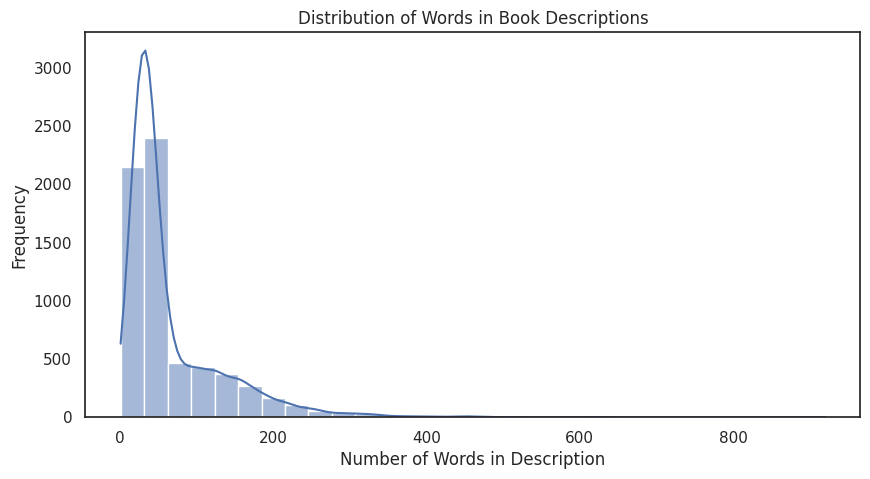

In [17]:
# Plot a histogram of word counts in book descriptions
plt.figure(figsize=(10, 5))
sns.histplot(book_missing["words_in_description"], bins=30, kde=True)

# Add labels and title
plt.xlabel("Number of Words in Description")
plt.ylabel("Frequency")
plt.title("Distribution of Words in Book Descriptions")

# Show the plot
plt.show()


In [18]:
book_missing.loc[book_missing["words_in_description"].between(1, 4), "description"]

,description
6,Donation.
11,Fantasy-roman.
748,Includes bibliographical references.
770,Bound For Oregon (PB)
775,No Marketing Blurb
812,No Marketing Blurb
857,First published in 1813.
944,Edited by Maurice Hindle.
953,DEFOE/ROBINSON CRUSOE (BC)
954,Edited by John Carey.


In [19]:
# Filter the dataset to select books where the description has between 5 and 14 words
book_missing.loc[book_missing["words_in_description"].between(5, 14), "description"]

,description
2,Volume Two of Stephen Donaldson's acclaimed se...
38,Koko is Peter Straub's foray into the psycholo...
70,A matter of life and death - and the Throne of...
77,Nonsense rhyming story. 4 yrs+
84,A study guide for the novel There's a Boy in t...
...,...
6715,The first comprehensive guide to addressing Na...
6726,Presents two complete novels from Henry James.
6757,Audio Book- unabriged on CD
6776,Raymond Chandler meets The Exorcist. Classic n...


In [20]:
# Filter the dataset to select books where the description has between 15 and 24 words
book_missing.loc[book_missing["words_in_description"].between(15, 24), "description"]

,description
10,One of Sidney Sheldon's most popular and bests...
32,Tells the story of three generations of Chines...
36,A magical and fantastic collection of early st...
57,A young drifter finds more than he bargained f...
68,A new 'The Doors of Perception' for the 21st c...
...,...
6767,Everything from the fingerprints of the gods t...
6782,Displays one of America's leading physicist's ...
6783,Basics Illustration 01: Thinking Visually expl...
6789,Provides an introduction to the American artis...


In [21]:
# Filter the dataset to select books where the description has between 25 and 34 words
book_missing.loc[book_missing["words_in_description"].between(25, 34), "description"]

,description
9,Kate Blackwell is an enigma and one of the mos...
14,"Available in the U.S. for the first time, this..."
20,"It is 1937, and Charles Ashworth, a Canon to t..."
21,Reissue of the author's most famous and well-l...
46,No one believes a little girl when she insists...
...,...
6760,"Joel, an English teacher, has never really lik..."
6766,Discusses the historical and intellectual back...
6775,Presents nearly one thousand recipes--from app...
6779,Edited by the creator and executive producer o...


In [22]:
# Filter the dataset to keep only those rows where the description length is greater than 25 characters
book_missing[book_missing["description"].str.len() > 25]

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,words_in_description
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,20.0,199
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,24.0,205
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0,0,42.0,14
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,31.0,57
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,22.0,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6803,9788173031014,8173031010,Journey to the East,NaN,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,0,22.0,63
6804,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,NaN,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,0,21.0,117
6805,9788185300535,8185300534,I Am that,Talks with Sri Nisargadatta Maharaj,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,0,25.0,174
6808,9789027712059,9027712050,The Berlin Phenomenology,NaN,Georg Wilhelm Friedrich Hegel,History,http://books.google.com/books/content?id=Vy7Sk...,Since the three volume edition ofHegel's Philo...,1981.0,0.00,210.0,0.0,0,43.0,245


### Selecting a Threshold for Filtering Book Descriptions  

To refine our dataset, we have decided to filter books based on the length of their descriptions. We set a threshold of **25 characters**, meaning only books with descriptions **longer than 25 characters** will be retained.  

#### Why this threshold?  
- Very short descriptions might not provide enough useful information.  
- A description with more than 25 characters is likely to be more **meaningful** and **helpful** for users in choosing books.  
- This approach ensures that the dataset includes books with **substantial descriptions**, improving recommendation quality.  

This threshold acts as a **margin for filtering**, ensuring that we work with books that have informative summaries while avoiding overly short or missing descriptions.  


In [23]:
book_missing_25_words = book_missing[book_missing["words_in_description"] >= 25]
book_missing_25_words

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,words_in_description
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,20.0,199
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,24.0,205
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,31.0,57
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,22.0,45
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,0,22.0,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6802,9788172235222,8172235224,Mistaken Identity,NaN,Nayantara Sahgal,Indic fiction (English),http://books.google.com/books/content?id=q-tKP...,On A Train Journey Home To North India After L...,2003.0,2.93,324.0,0.0,0,21.0,288
6803,9788173031014,8173031010,Journey to the East,NaN,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,0,22.0,63
6804,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,NaN,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,0,21.0,117
6805,9788185300535,8185300534,I Am that,Talks with Sri Nisargadatta Maharaj,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,0,25.0,174


### Combining Title and Subtitle for Better Readability  

To enhance the clarity and usability of our dataset, we are creating a new column **`title_and_subtitle`** that merges the book's **title** and **subtitle** into a single field. This is done using the following approach:  

1. If a book **does not have a subtitle**, we retain only the **title**.  
2. If a book has both a **title** and a **subtitle**, we combine them using `": "` as a separator (e.g., *"The Great Gatsby: A Classic Novel"*).  

#### Why this step?  
- Some books have **only a title**, while others include a **subtitle** that provides more context.  
- Combining both ensures a **consistent format** across all entries.  
- It improves the dataset's **readability and usability** for recommendations or further analysis.  

By doing this, we ensure that all books have a properly structured title, making the dataset more informative and user-friendly.  


In [24]:
book_missing_25_words['title_and_subtitle'] = (
    np.where(
        book_missing_25_words['subtitle'].isna(),
        book_missing_25_words['title'],
        book_missing_25_words[["title", "subtitle"]].astype(str).agg(": ".join, axis=1))
)
book_missing_25_words

<ipython-input-24-afbfa67f4df1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_missing_25_words['title_and_subtitle'] = (


,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,words_in_description,title_and_subtitle
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,20.0,199,Gilead
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,24.0,205,Spider's Web: A Novel
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,31.0,57,Rage of angels
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,22.0,45,The Four Loves
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,0,22.0,75,The Problem of Pain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6802,9788172235222,8172235224,Mistaken Identity,NaN,Nayantara Sahgal,Indic fiction (English),http://books.google.com/books/content?id=q-tKP...,On A Train Journey Home To North India After L...,2003.0,2.93,324.0,0.0,0,21.0,288,Mistaken Identity
6803,9788173031014,8173031010,Journey to the East,NaN,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,0,22.0,63,Journey to the East
6804,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,NaN,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,0,21.0,117,The Monk Who Sold His Ferrari: A Fable About F...
6805,9788185300535,8185300534,I Am that,Talks with Sri Nisargadatta Maharaj,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,0,25.0,174,I Am that: Talks with Sri Nisargadatta Maharaj


In [25]:
book_missing_25_words["tagged_description"] = book_missing_25_words[["isbn13", "description"]].astype(str).agg("".join, axis=1)

<ipython-input-25-a60a490ce954>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_missing_25_words["tagged_description"] = book_missing_25_words[["isbn13", "description"]].astype(str).agg("".join, axis=1)


In [26]:
(
    book_missing_25_words
    .drop(["subtitle", "missing_description", "age_of_book", "words_in_description"], axis = 1)
    .to_csv("books_cleaned.csv", index=False)
)